### Mental-RoBERTa
[Training - Mental-RoBERTa + Original labels](#1)  
[Training - Mental-RoBERTa + Original labels + Personality (Benchmark)](#2)            
[Training - Mental-RoBERTa + Relabeled data](#3)       
[Training - Mental-RoBERTa + Relabeled + Personality](#4)      

<u>[Testing results](#5)</u>  
[Mental-RoBERTa + Original labels](#6)  
[Mental-RoBERTa + Original labels + Personality (Benchmark)](#7)            
[Mental-RoBERTa + Relabeled data](#8)       
[Mental-RoBERTa + Relabeled + Personality](#9)     
[Mental-RoBERTa + Relabeled data + NLI](#10)       
[Mental-RoBERTa + Relabeled + Personality + NLI](#11)       

In [4]:
import random
import numpy as np
import torch

# Set the seed value
seed_val = 42

# Python random
random.seed(seed_val)

# NumPy random
np.random.seed(seed_val)

# PyTorch random
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



In [5]:
#Import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import re
from nltk.tokenize import TweetTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, RobertaModel, RobertaConfig, RobertaPreTrainedModel, AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AutoConfig
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
import torch.nn as nn
import os

In [3]:
data = pd.read_csv('../dataset/relabeled_2000_samples_2.csv', encoding='utf-8-sig')

data

,Column1,text,ori_class,cleaned_text,true_class,openness,conscientiousness,extraversion,agreeableness,neuroticism
0,79033,Here are some jokes that don't have a punchlin...,non-suicide,Here are some jokes that don't have a punchlin...,non-suicide,0.862079,0.632528,0.299561,0.650520,0.004304
1,257115,I'll begin to blog on here before I end it on ...,suicide,I'll begin to blog on here before I end it on ...,suicide,0.561344,0.527004,0.222416,0.461801,0.022128
2,102858,"Just saw two friends vape, Do I snitch? So I l...",non-suicide,"Just saw two friends vape, Do I snitch? So I l...",non-suicide,0.726340,0.389685,0.347877,0.707561,0.022913
3,188810,Hey lads! Can I get some help from y'all? So.....,non-suicide,Hey lads! Can I get some help from y'all? So.....,non-suicide,0.753932,0.489636,0.230587,0.776817,0.031480
4,88124,Why do parents always bring up their “stories”...,non-suicide,"Why do parents always bring up their ""stories""...",non-suicide,0.802898,0.768912,0.275205,0.437977,0.032501
...,...,...,...,...,...,...,...,...,...,...
1995,272846,ContemplationI have everything I need to do It...,suicide,Contemplation. I have everything I need to do ...,suicide,0.747140,0.331684,0.412662,0.536295,0.939585
1996,49620,"I don't want to get better, I want to get wors...",suicide,"I don't want to get better, I want to get wors...",suicide,0.437285,0.340145,0.125675,0.653872,0.946523
1997,291094,My only friend died and I want to go with him....,suicide,My only friend died and I want to go with him....,suicide,0.395193,0.474021,0.074487,0.620530,0.958698
1998,138491,I fantasize about dying all the timeI think th...,suicide,I fantasize about dying all the time. I think ...,suicide,0.604205,0.529648,0.226070,0.512029,0.966551


#### 1
- Original labels (2000 samples)
- textual features only

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, precision_score, recall_score, roc_curve, auc

texts = data['cleaned_text'].tolist()
labels = data['ori_class'].map({'suicide': 1, 'non-suicide': 0})
tokenizer = AutoTokenizer.from_pretrained(
    "mental/mental-roberta-base",
    token=True  
)

input_ids = []
attention_masks = []

# tokenize and encode sequences in the training set
encoded_data = tokenizer.batch_encode_plus(
    texts.tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=512,
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(labels.values, dtype=torch.long)  # ensure integer labels

dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=8,
    pin_memory=True
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=8,
    pin_memory=True
)

config = AutoConfig.from_pretrained(
    "mental/mental-roberta-base",
    num_labels=2,
    hidden_dropout_prob=0.3,      
    attention_probs_dropout_prob=0.3  
)

model = AutoModelForSequenceClassification.from_pretrained('mental/mental-roberta-base',config=config)

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# use cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(4):

    # train loop
    model.train()
    total_train_loss = 0
    total_val_loss = 0
    
    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)

    # validation loop
    model.eval()
    val_labels = []
    val_preds = []
    val_probs = []

    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs.loss
        total_val_loss += loss.item()

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # calculate probabilities for roc_auc_score
        probs = torch.nn.functional.softmax(torch.from_numpy(logits), dim=1).numpy()
        val_probs.extend(probs)

        predictions = np.argmax(logits, axis=1)
        val_labels.extend(label_ids)
        val_preds.extend(predictions)
    
    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f}")
    print(f"  Val Acc:    {val_accuracy:.4f}")
    print("-" * 30)

print('Mental-RoBERTa Results:')
print(classification_report(val_labels, val_preds, digits=4))


c:\Users\PC\Documents\Master_Project\Suicide-Ideation-Detection-in-Social-Media-Using-Personality-Traits-main\venv\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at mental/mental-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1
  Train Loss: 0.4568
  Val Loss:   0.2571
  Val Acc:    0.9050
------------------------------
Epoch 2
  Train Loss: 0.2369
  Val Loss:   0.3760
  Val Acc:    0.8625
------------------------------
Epoch 3
  Train Loss: 0.1900
  Val Loss:   0.2550
  Val Acc:    0.9050
------------------------------
Epoch 4
  Train Loss: 0.1321
  Val Loss:   0.3687
  Val Acc:    0.8975
------------------------------
Mental-RoBERTa Results:
              precision    recall  f1-score   support

           0     1.0000    0.7865    0.8805       192
           1     0.8353    1.0000    0.9103       208

    accuracy                         0.8975       400
   macro avg     0.9177    0.8932    0.8954       400
weighted avg     0.9144    0.8975    0.8960       400



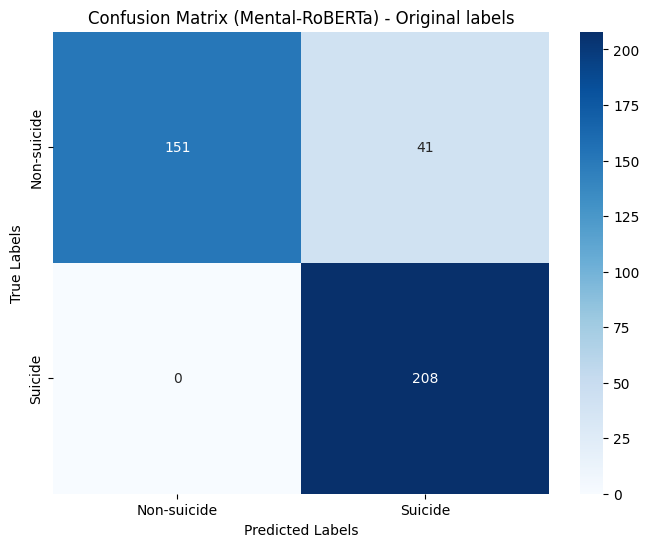

In [5]:
# Calculate confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Mental-RoBERTa) - Original labels')
plt.show()


In [6]:
# Save the model
output_dir = "../saved_models/mental_roberta_raw"

#save misclassified samples
val_indices = val_dataset.indices if hasattr(val_dataset, 'indices') else np.arange(len(val_dataset))

val_texts = [texts[i] for i in val_indices]
val_true_labels = [labels[i].item() for i in val_indices]  
val_pred_labels = val_preds  


val_df = pd.DataFrame({
    'text': val_texts,
    'true_label': val_true_labels,
    'pred_label': val_pred_labels
})

# Filter misclassified samples
misclassified_df = val_df[val_df['true_label'] != val_df['pred_label']]

# Optionally, map label numbers back to class names
label_map = {0: 'non-suicide', 1: 'suicide'}
misclassified_df['true_label_name'] = misclassified_df['true_label'].map(label_map)
misclassified_df['pred_label_name'] = misclassified_df['pred_label'].map(label_map)

print(f"Number of misclassified samples: {len(misclassified_df)}")
print(misclassified_df.head(10))  # view first 10 misclassified samples

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save model
torch.save(model.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

misclassified_df.to_csv(output_dir + '/misclassified_samples.csv', index=False, encoding='utf-8-sig')

print(f"Model state dict and tokenizer saved to {output_dir}")

C:\Users\PC\AppData\Local\Temp\ipykernel_10624\2278315184.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['true_label_name'] = misclassified_df['true_label'].map(label_map)
C:\Users\PC\AppData\Local\Temp\ipykernel_10624\2278315184.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['pred_label_name'] = misclassified_df['pred_label'].map(label_map)


Number of misclassified samples: 41
                                                 text  true_label  pred_label  \
5   A rant, if you will. This is almost everything...           0           1   
10  I'm insanely paranoid rn someone hear me out p...           0           1   
11  Why do people make me feel disregarded and uni...           0           1   
30  WHY ME Every time I send a message. Always in ...           0           1   
34  I think I should be back in the mental hospita...           0           1   
41  My life right now I literally just woke up fro...           0           1   
42  I got offered to go to Harvard. I'm stressed a...           0           1   
53  I really want to see my friend again. I met on...           0           1   
55  I miss affection. To the few people who see th...           0           1   
56  I'm happy. A few years ago, I was extremely de...           0           1   

   true_label_name pred_label_name  
5      non-suicide         suicide 

### 2 
- Original labels (2000 samples)
- Textual features + Personality

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, precision_score, recall_score, roc_curve, auc

# === Load data including personality features ===
texts = data['cleaned_text'].tolist()
labels = data['ori_class'].map({'suicide': 1, 'non-suicide': 0})
personality_features = data[["extraversion", "agreeableness", "neuroticism"]].values
personality_features = torch.tensor(personality_features, dtype=torch.float32)

tokenizer = AutoTokenizer.from_pretrained('mental/mental-roberta-base')

input_ids = []
attention_masks = []

# tokenize and encode sequences in the training set
encoded_data = tokenizer.batch_encode_plus(
    texts,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=512,
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(labels.values, dtype=torch.long) 

# Dataset with text tokens + personality features
class RoBertaWithPersonalityDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, personality_feats, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.personality_feats = personality_feats
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (self.input_ids[idx],
                self.attention_masks[idx],
                self.personality_feats[idx],
                self.labels[idx])
    
dataset = RoBertaWithPersonalityDataset(input_ids, attention_masks, personality_features, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=8,
    pin_memory=True
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=8,
    pin_memory=True
)

# ===== Custom model combining RoBERTa+ Personality Features =====
class RoBertaWithPersonality(RobertaPreTrainedModel):
    def __init__(self, config, personality_feat_dim=3, num_labels=2):
        super().__init__(config)
        self.bert = RobertaModel.from_pretrained("mental/mental-roberta-base", config=config)
        bert_hidden_size = config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(bert_hidden_size + personality_feat_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )

    def forward(self, input_ids, attention_mask, personality_feats, labels=None):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = bert_outputs.last_hidden_state[:, 0, :]  # CLS token embedding
        combined = torch.cat((cls_output, personality_feats), dim=1)
        logits = self.classifier(combined)

        return logits


# ===== Config =====
config = AutoConfig.from_pretrained(
    'mental/mental-roberta-base',
    num_labels=2,
    hidden_dropout_prob=0.3,          
    attention_probs_dropout_prob=0.3  
)

model = RoBertaWithPersonality.from_pretrained("mental/mental-roberta-base", config=config)

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

# Use CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


# ===== Training Loop =====
for epoch in range(4):
    # Training
    model.train()
    total_train_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_personality, b_labels = batch

        model.zero_grad()
        logits = model(b_input_ids, attention_mask=b_input_mask, personality_feats=b_personality)

        loss = criterion(logits, b_labels)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    total_val_loss = 0
    val_labels, val_preds, val_probs = [], [], []

    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_personality, b_labels = batch

        with torch.no_grad():
            logits = model(b_input_ids, attention_mask=b_input_mask, personality_feats=b_personality)
            loss = criterion(logits, b_labels)
            total_val_loss += loss.item()

            label_ids = b_labels.to('cpu').numpy()

            # Probabilities for ROC-AUC
            probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
            val_probs.extend(probs)

            predictions = np.argmax(logits.cpu().numpy(), axis=1)
            val_labels.extend(label_ids)
            val_preds.extend(predictions)

    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f}")
    print(f"  Val Acc:    {val_accuracy:.4f}")
    print("-" * 30)

print("RoBERTa Results:")
print(classification_report(val_labels, val_preds, digits=4))


Some weights of RobertaModel were not initialized from the model checkpoint at mental/mental-roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RoBertaWithPersonality were not initialized from the model checkpoint at mental/mental-roberta-base and are newly initialized: ['roberta.bert.embeddings.LayerNorm.bias', 'roberta.bert.embeddings.LayerNorm.weight', 'roberta.bert.embeddings.position_embeddings.weight', 'roberta.bert.embeddings.token_type_embeddings.weight', 'roberta.bert.embeddings.word_embeddings.weight', 'roberta.bert.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.bert.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.bert.encoder.layer.0.attention.output.dense.bias', 'roberta.bert.encoder.layer.0.attention.output.dense.weight', 'roberta.bert.encoder.layer.0.attention.self.key.bias

Epoch 1
  Train Loss: 0.5542
  Val Loss:   0.3303
  Val Acc:    0.8900
------------------------------
Epoch 2
  Train Loss: 0.3006
  Val Loss:   0.3437
  Val Acc:    0.8900
------------------------------
Epoch 3
  Train Loss: 0.2275
  Val Loss:   0.3568
  Val Acc:    0.8800
------------------------------
Epoch 4
  Train Loss: 0.2017
  Val Loss:   0.2807
  Val Acc:    0.9000
------------------------------
RoBERTa Results:
              precision    recall  f1-score   support

           0     0.9932    0.7903    0.8802       186
           1     0.8452    0.9953    0.9142       214

    accuracy                         0.9000       400
   macro avg     0.9192    0.8928    0.8972       400
weighted avg     0.9141    0.9000    0.8984       400



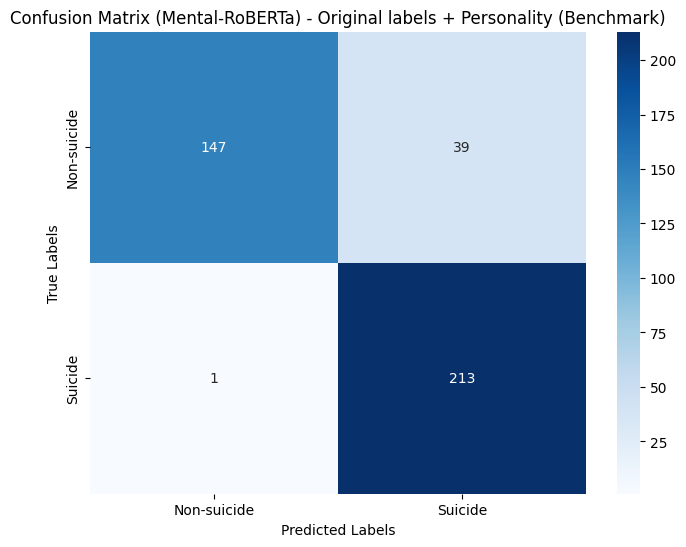

In [9]:
# Calculate confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Mental-RoBERTa) - Original labels + Personality (Benchmark)')
plt.show()


In [10]:
# Save the model
output_dir = "../saved_models/mental_roberta_raw_personality"

#save misclassified samples
val_indices = val_dataset.indices if hasattr(val_dataset, 'indices') else np.arange(len(val_dataset))

val_texts = [texts[i] for i in val_indices]
val_true_labels = [labels[i].item() for i in val_indices]  
val_pred_labels = val_preds  


val_df = pd.DataFrame({
    'text': val_texts,
    'true_label': val_true_labels,
    'pred_label': val_pred_labels
})

# Filter misclassified samples
misclassified_df = val_df[val_df['true_label'] != val_df['pred_label']]

# Optionally, map label numbers back to class names
label_map = {0: 'non-suicide', 1: 'suicide'}
misclassified_df['true_label_name'] = misclassified_df['true_label'].map(label_map)
misclassified_df['pred_label_name'] = misclassified_df['pred_label'].map(label_map)

print(f"Number of misclassified samples: {len(misclassified_df)}")
print(misclassified_df.head(10))  # view first 10 misclassified samples

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save model
torch.save(model.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

misclassified_df.to_csv(output_dir + '/misclassified_samples.csv', index=False, encoding='utf-8-sig')

print(f"Model state dict and tokenizer saved to {output_dir}")

Number of misclassified samples: 40
                                                 text  true_label  pred_label  \
0   MEN: Innovate The Stigma Innovative Approach T...           0           1   
10  Being lonely kinda sucks I'm only human, and I...           0           1   
41  Hi, just dropping something off I needa say so...           0           1   
56  Fuck me, guys.... So I'm not trying to toot my...           0           1   
63  Don't do what I did Basically I wasted my diam...           0           1   
67  You ever look at your life..... And realize th...           0           1   
79  i hate my mother im being serious. i dont like...           0           1   
81  I dont know how to make good friends. Long sto...           0           1   
87  One of our two kittens passed away today. The ...           0           1   
88  I'm just going to rant about how perfect my fr...           0           1   

   true_label_name pred_label_name  
0      non-suicide         suicide 

C:\Users\PC\AppData\Local\Temp\ipykernel_10624\2313390417.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['true_label_name'] = misclassified_df['true_label'].map(label_map)
C:\Users\PC\AppData\Local\Temp\ipykernel_10624\2313390417.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['pred_label_name'] = misclassified_df['pred_label'].map(label_map)


Model state dict and tokenizer saved to ../saved_models/mental_roberta_raw_personality


#### 3
- relabeled 2000 samples
- textual features only

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, precision_score, recall_score, roc_curve, auc


texts = data['cleaned_text'].tolist()
labels = data['true_class'].map({'suicide': 1, 'non-suicide': 0})
tokenizer = AutoTokenizer.from_pretrained("mental/mental-roberta-base")

input_ids = []
attention_masks = []

# tokenize and encode sequences in the training set
encoded_data = tokenizer.batch_encode_plus(
    texts,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=512,
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(labels.values, dtype=torch.long)  # ensure integer labels

dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=8,
    pin_memory=True
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=8,
    pin_memory=True
)

config = AutoConfig.from_pretrained(
    "mental/mental-roberta-base",
    num_labels=2,
    hidden_dropout_prob=0.3,      
    attention_probs_dropout_prob=0.3  
)

model = AutoModelForSequenceClassification.from_pretrained(
    "mental/mental-roberta-base",
    config=config
)

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# use cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(4):

    # train loop
    model.train()
    total_train_loss = 0
    total_val_loss = 0
    
    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)

    # validation loop
    model.eval()
    val_labels = []
    val_preds = []
    val_probs = []

    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs.loss
        total_val_loss += loss.item()

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # calculate probabilities for roc_auc_score
        probs = torch.nn.functional.softmax(torch.from_numpy(logits), dim=1).numpy()
        val_probs.extend(probs)

        predictions = np.argmax(logits, axis=1)
        val_labels.extend(label_ids)
        val_preds.extend(predictions)
    
    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f}")
    print(f"  Val Acc:    {val_accuracy:.4f}")
    print("-" * 30)

print('RoBERTa Results:')
print(classification_report(val_labels, val_preds, digits=4))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at mental/mental-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1
  Train Loss: 0.4914
  Val Loss:   0.2174
  Val Acc:    0.9150
------------------------------
Epoch 2
  Train Loss: 0.2288
  Val Loss:   0.1983
  Val Acc:    0.9200
------------------------------
Epoch 3
  Train Loss: 0.1715
  Val Loss:   0.1820
  Val Acc:    0.9375
------------------------------
Epoch 4
  Train Loss: 0.1497
  Val Loss:   0.1940
  Val Acc:    0.9375
------------------------------
RoBERTa Results:
              precision    recall  f1-score   support

           0     0.9368    0.9319    0.9344       191
           1     0.9381    0.9426    0.9403       209

    accuracy                         0.9375       400
   macro avg     0.9375    0.9373    0.9374       400
weighted avg     0.9375    0.9375    0.9375       400



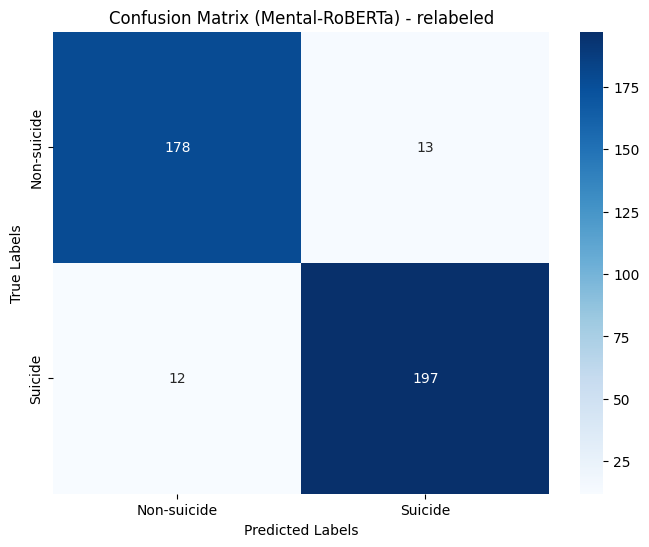

In [12]:
# Calculate confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Mental-RoBERTa) - relabeled')
plt.show()


In [13]:
#save misclassified samples
val_indices = val_dataset.indices if hasattr(val_dataset, 'indices') else np.arange(len(val_dataset))

val_texts = [texts[i] for i in val_indices]
val_true_labels = [labels[i].item() for i in val_indices]  
val_pred_labels = val_preds  


val_df = pd.DataFrame({
    'text': val_texts,
    'true_label': val_true_labels,
    'pred_label': val_pred_labels
})

# Filter misclassified samples
misclassified_df = val_df[val_df['true_label'] != val_df['pred_label']]

# Optionally, map label numbers back to class names
label_map = {0: 'non-suicide', 1: 'suicide'}
misclassified_df['true_label_name'] = misclassified_df['true_label'].map(label_map)
misclassified_df['pred_label_name'] = misclassified_df['pred_label'].map(label_map)

print(f"Number of misclassified samples: {len(misclassified_df)}")
print(misclassified_df.head(10))  

# Save the model
output_dir = "../saved_models/mental_roberta_relabeled"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save model
torch.save(model.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

misclassified_df.to_csv(output_dir + '/misclassified_samples.csv', index=False, encoding='utf-8-sig')

print(f"Model state dict and tokenizer saved to {output_dir}")

Number of misclassified samples: 25
                                                  text  true_label  \
2    Update. A while back I'd posted about some sui...           0   
12   Count Down To Death Date: 2I had a dream last ...           1   
17   Social anxiety has taken everything.Most of yo...           1   
37   I need your help, fellow suicide watch users. ...           0   
43   i might do my plan today im sorry. I've been p...           1   
54   How can I get over the past?When I was around ...           1   
74   I only get good grades to look good in front o...           0   
164  You ever look at your life..... And realize th...           0   
181  I made a power point.I don't know how you migh...           1   
204  Hey.Hey guys... First of all pls don't make fu...           1   

     pred_label true_label_name pred_label_name  
2             1     non-suicide         suicide  
12            0         suicide     non-suicide  
17            0         suicide     non-sui

C:\Users\PC\AppData\Local\Temp\ipykernel_10624\408416877.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['true_label_name'] = misclassified_df['true_label'].map(label_map)
C:\Users\PC\AppData\Local\Temp\ipykernel_10624\408416877.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['pred_label_name'] = misclassified_df['pred_label'].map(label_map)


Model state dict and tokenizer saved to ../saved_models/mental_roberta_relabeled


#### 4
- relabeled 2000 samples
- textual features + personality

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, precision_score, recall_score, roc_curve, auc

# === Load data including personality features ===
texts = data['cleaned_text'].tolist()
labels = data['true_class'].map({'suicide': 1, 'non-suicide': 0})
personality_features = data[["extraversion", "agreeableness", "neuroticism"]].values
personality_features = torch.tensor(personality_features, dtype=torch.float32)

tokenizer = AutoTokenizer.from_pretrained('mental/mental-roberta-base')

input_ids = []
attention_masks = []

# tokenize and encode sequences in the training set
encoded_data = tokenizer.batch_encode_plus(
    texts,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=512,
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(labels.values, dtype=torch.long) 

# Dataset with text tokens + personality features
class RoBertaWithPersonalityDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, personality_feats, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.personality_feats = personality_feats
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (self.input_ids[idx],
                self.attention_masks[idx],
                self.personality_feats[idx],
                self.labels[idx])
    
dataset = RoBertaWithPersonalityDataset(input_ids, attention_masks, personality_features, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=8,
    pin_memory=True
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=8,
    pin_memory=True
)

# ===== Custom model combining RoBERTa + Personality Features =====
class RoBertaWithPersonality(RobertaPreTrainedModel):
    def __init__(self, config, personality_feat_dim=3, num_labels=2):
        super().__init__(config)
        self.bert = RobertaModel.from_pretrained("mental/mental-roberta-base", config=config)
        bert_hidden_size = config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(bert_hidden_size + personality_feat_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )

        self.init_weights()

    def forward(self, input_ids, attention_mask, personality_feats, labels=None):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = bert_outputs.last_hidden_state[:, 0, :]  # CLS token embedding
        combined = torch.cat((cls_output, personality_feats), dim=1)
        logits = self.classifier(combined)

        return logits


# ===== Config =====
config = AutoConfig.from_pretrained(
    'mental/mental-roberta-base',
    num_labels=2,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)

model = RoBertaWithPersonality.from_pretrained("mental/mental-roberta-base", config=config)

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

# Use CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# ===== Training Loop =====
for epoch in range(4):
    # Training
    model.train()
    total_train_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_personality, b_labels = batch

        model.zero_grad()
        logits = model(b_input_ids, attention_mask=b_input_mask, personality_feats=b_personality)

        loss = criterion(logits, b_labels)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    total_val_loss = 0
    val_labels, val_preds, val_probs = [], [], []

    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_personality, b_labels = batch

        with torch.no_grad():
            logits = model(b_input_ids, attention_mask=b_input_mask, personality_feats=b_personality)
            loss = criterion(logits, b_labels)
            total_val_loss += loss.item()

            label_ids = b_labels.to('cpu').numpy()

            # Probabilities for ROC-AUC
            probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
            val_probs.extend(probs)

            predictions = np.argmax(logits.cpu().numpy(), axis=1)
            val_labels.extend(label_ids)
            val_preds.extend(predictions)

    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}")
    print(f" Train Loss: {avg_train_loss:.4f}")
    print(f" Val Loss: {avg_val_loss:.4f}")
    print(f" Val Acc: {val_accuracy:.4f}")
    print("-" * 30)

print("RoBERTa Results:")
print(classification_report(val_labels, val_preds, digits=4))


Some weights of RobertaModel were not initialized from the model checkpoint at mental/mental-roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RoBertaWithPersonality were not initialized from the model checkpoint at mental/mental-roberta-base and are newly initialized: ['roberta.bert.embeddings.LayerNorm.bias', 'roberta.bert.embeddings.LayerNorm.weight', 'roberta.bert.embeddings.position_embeddings.weight', 'roberta.bert.embeddings.token_type_embeddings.weight', 'roberta.bert.embeddings.word_embeddings.weight', 'roberta.bert.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.bert.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.bert.encoder.layer.0.attention.output.dense.bias', 'roberta.bert.encoder.layer.0.attention.output.dense.weight', 'roberta.bert.encoder.layer.0.attention.self.key.bias

Epoch 1
 Train Loss: 0.5424
 Val Loss: 0.3457
 Val Acc: 0.8700
------------------------------
Epoch 2
 Train Loss: 0.2719
 Val Loss: 0.2261
 Val Acc: 0.9225
------------------------------
Epoch 3
 Train Loss: 0.2007
 Val Loss: 0.2413
 Val Acc: 0.9125
------------------------------
Epoch 4
 Train Loss: 0.1568
 Val Loss: 0.2308
 Val Acc: 0.9225
------------------------------
RoBERTa Results:
              precision    recall  f1-score   support

           0     0.9818    0.8526    0.9127       190
           1     0.8809    0.9857    0.9303       210

    accuracy                         0.9225       400
   macro avg     0.9313    0.9192    0.9215       400
weighted avg     0.9288    0.9225    0.9219       400



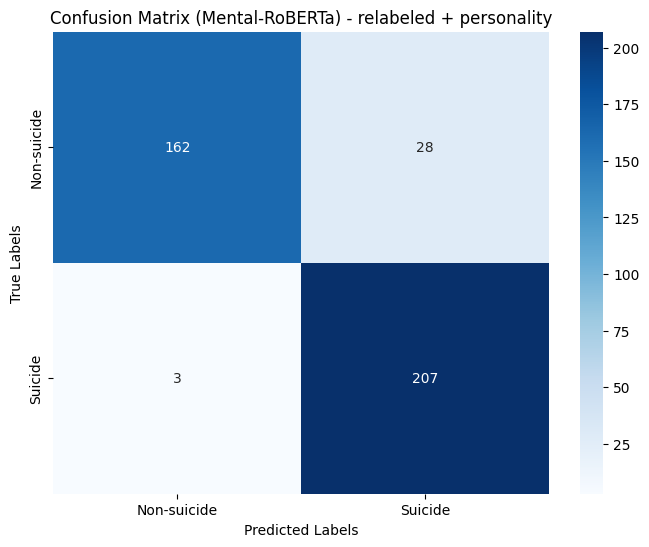

In [15]:
# Calculate confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Mental-RoBERTa) - relabeled + personality')
plt.show()


In [16]:
#save misclassified samples
val_indices = val_dataset.indices if hasattr(val_dataset, 'indices') else np.arange(len(val_dataset))

val_texts = [texts[i] for i in val_indices]
val_true_labels = [labels[i].item() for i in val_indices]  
val_pred_labels = val_preds  


val_df = pd.DataFrame({
    'text': val_texts,
    'true_label': val_true_labels,
    'pred_label': val_pred_labels
})

# Filter misclassified samples
misclassified_df = val_df[val_df['true_label'] != val_df['pred_label']]

# Optionally, map label numbers back to class names
label_map = {0: 'non-suicide', 1: 'suicide'}
misclassified_df['true_label_name'] = misclassified_df['true_label'].map(label_map)
misclassified_df['pred_label_name'] = misclassified_df['pred_label'].map(label_map)

print(f"Number of misclassified samples: {len(misclassified_df)}")
print(misclassified_df.head(10))  # view first 10 misclassified samples

# Save the model
output_dir = "../saved_models/mental_roberta_personality"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save model
torch.save(model.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

misclassified_df.to_csv(output_dir + '/misclassified_samples.csv', index=False, encoding='utf-8-sig')

print(f"Model state dict and tokenizer saved to {output_dir}")

Number of misclassified samples: 31
                                                  text  true_label  \
5    i feel so devastated and i miss them its alway...           0   
58   Lost one of my employees to suicide.I realize ...           0   
63   I am a bit down I don't really know why .like ...           0   
77   Apparently it gets better Listen, a few weeks ...           0   
78   Finding hope. I have learned to find hope that...           0   
80   relationships suck assi just want to talk to s...           1   
96   I ruined my family.(I have no idea of where to...           1   
115  i don't even think I'm going to make it to spr...           0   
116  I lost my two best friends I don't know what t...           0   
122  I wanna off myself so bad so fucking bad what ...           0   

     pred_label true_label_name pred_label_name  
5             1     non-suicide         suicide  
58            1     non-suicide         suicide  
63            1     non-suicide         sui

C:\Users\PC\AppData\Local\Temp\ipykernel_10624\2637728455.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['true_label_name'] = misclassified_df['true_label'].map(label_map)
C:\Users\PC\AppData\Local\Temp\ipykernel_10624\2637728455.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['pred_label_name'] = misclassified_df['pred_label'].map(label_map)


Model state dict and tokenizer saved to ../saved_models/mental_roberta_personality


### 5
### Testing results

#### 6

In [6]:
# RoBERTa+ Original Labels
import torch
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# ===== Load dataset =====
df = pd.read_csv('../dataset/testing_1000_samples_2.csv')

# Map string labels to integers
label_map = {"non-suicide": 0, "suicide": 1}
true_labels_int = df['true_class'].map(label_map).values

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Load RoBERTasuicide classifier =====
model_dir = "../saved_models/mental_roberta_raw"
bert_model = AutoModelForSequenceClassification.from_pretrained(model_dir)
bert_model.to(device).eval()
bert_tokenizer = AutoTokenizer.from_pretrained(model_dir)

# ===== Parameters =====
batch_size = 16  # adjust based on GPU memory
final_predictions = []

# ===== Batching for RoBERTa inference =====
for i in range(0, len(df), batch_size):
    batch_texts = df['cleaned_text'][i:i+batch_size].tolist()
    
    # RoBERTa tokenization
    encodings = bert_tokenizer(
        batch_texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)
    
    # RoBERTa predictions
    with torch.no_grad():
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
    
    final_predictions.extend(batch_preds)
    
    # Free GPU memory
    torch.cuda.empty_cache()

# ===== Evaluation =====
df['Predicted_Label'] = ["non-suicide" if p==0 else "suicide" for p in final_predictions]

cm = confusion_matrix(true_labels_int, final_predictions)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(true_labels_int, final_predictions, target_names=["Non-suicide", "Suicide"], zero_division=0))


Confusion Matrix:
[[393 107]
 [  5 495]]

Classification Report:
              precision    recall  f1-score   support

 Non-suicide       0.99      0.79      0.88       500
     Suicide       0.82      0.99      0.90       500

    accuracy                           0.89      1000
   macro avg       0.90      0.89      0.89      1000
weighted avg       0.90      0.89      0.89      1000



#### 7

In [7]:
# RoBERTa + Original Labels + Personality Evaluation 
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# ===== Load dataset =====
df = pd.read_csv('../dataset/testing_1000_samples_2.csv')
true_labels = df['true_class'].map({'non-suicide':0, 'suicide':1}).values

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Load personality features =====
personality_features = df[["extraversion", "agreeableness", "neuroticism"]].values
personality_features = torch.tensor(personality_features, dtype=torch.float32).to(device)

# ===== Tokenizer =====
bert_tokenizer = AutoTokenizer.from_pretrained('../saved_models/mental_roberta_raw_personality')

class RoBertaWithPersonality(RobertaPreTrainedModel):
    def __init__(self, config, personality_feat_dim=3, num_labels=2):
        super().__init__(config)
        self.bert = RobertaModel.from_pretrained("mental/mental-roberta-base", config=config)
        bert_hidden_size = config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(bert_hidden_size + personality_feat_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )

        self.init_weights()

    def forward(self, input_ids, attention_mask, personality_feats, labels=None):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = bert_outputs.last_hidden_state[:, 0, :]  # CLS token embedding
        combined = torch.cat((cls_output, personality_feats), dim=1)
        logits = self.classifier(combined)

        return logits

# ===== Load pretrained RoBERTa + Personality model =====
config = AutoConfig.from_pretrained('mental/mental-roberta-base', num_labels=2)
bert_personality_model = RoBertaWithPersonality.from_pretrained('../saved_models/mental_roberta_raw_personality', config=config)
bert_personality_model.to(device).eval()

# ===== Parameters =====
batch_size = 16
final_predictions = []

# ===== Batching for RoBERTa + Personality inference =====
for i in range(0, len(df), batch_size):
    batch_texts = df['cleaned_text'][i:i+batch_size].tolist()
    batch_personality = personality_features[i:i+batch_size]

    # RoBERTa tokenization
    encodings = bert_tokenizer(
        batch_texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    # RoBERTa + Personality predictions
    with torch.no_grad():
        logits = bert_personality_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            personality_feats=batch_personality
        )
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
        final_predictions.extend(batch_preds)

    # Free GPU memory
    torch.cuda.empty_cache()

# ===== Evaluation =====
df['Predicted_Label'] = ["non-suicide" if p==0 else "suicide" for p in final_predictions]

cm = confusion_matrix(true_labels, final_predictions)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(true_labels, final_predictions, target_names=["Non-suicide","Suicide"], zero_division=0))


c:\Users\PC\Documents\Master_Project\Suicide-Ideation-Detection-in-Social-Media-Using-Personality-Traits-main\venv\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of RobertaModel were not initialized from the model checkpoint at mental/mental-roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Confusion Matrix:
[[394 106]
 [  5 495]]

Classification Report:
              precision    recall  f1-score   support

 Non-suicide       0.99      0.79      0.88       500
     Suicide       0.82      0.99      0.90       500

    accuracy                           0.89      1000
   macro avg       0.91      0.89      0.89      1000
weighted avg       0.91      0.89      0.89      1000



#### 8

In [8]:
# RoBERTa + Relabeled Data Evaluation
import torch
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# ===== Load dataset =====
df = pd.read_csv('../dataset/testing_1000_samples_2.csv')

# Map string labels to integers
label_map = {"non-suicide": 0, "suicide": 1}
true_labels_int = df['true_class'].map(label_map).values

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Load RoBERTa suicide classifier =====
model_dir = "../saved_models/mental_roberta_relabeled"
bert_model = AutoModelForSequenceClassification.from_pretrained(model_dir)
bert_model.to(device).eval()
bert_tokenizer = AutoTokenizer.from_pretrained(model_dir)

# ===== Parameters =====
batch_size = 16  # adjust based on GPU memory
final_predictions = []

# ===== Batching for RoBERTa inference =====
for i in range(0, len(df), batch_size):
    batch_texts = df['cleaned_text'][i:i+batch_size].tolist()
    
    # RoBERTa tokenization
    encodings = bert_tokenizer(
        batch_texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)
    
    # RoBERTa predictions
    with torch.no_grad():
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
    
    final_predictions.extend(batch_preds)
    
    # Free GPU memory
    torch.cuda.empty_cache()

# ===== Evaluation =====
df['Predicted_Label'] = ["non-suicide" if p==0 else "suicide" for p in final_predictions]

cm = confusion_matrix(true_labels_int, final_predictions)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(true_labels_int, final_predictions, target_names=["Non-suicide", "Suicide"], zero_division=0))


Confusion Matrix:
[[469  31]
 [ 26 474]]

Classification Report:
              precision    recall  f1-score   support

 Non-suicide       0.95      0.94      0.94       500
     Suicide       0.94      0.95      0.94       500

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



#### 9 

In [9]:
# RoBERTa + Relabeled Data + Personality Evaluation 
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# ===== Load dataset =====
df = pd.read_csv('../dataset/testing_1000_samples_2.csv')
true_labels = df['true_class'].map({'non-suicide':0, 'suicide':1}).values

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Load personality features =====
personality_features = df[["extraversion", "agreeableness", "neuroticism"]].values
personality_features = torch.tensor(personality_features, dtype=torch.float32).to(device)

# ===== Tokenizer =====
bert_tokenizer = AutoTokenizer.from_pretrained('../saved_models/mental_roberta_personality')

class RoBertaWithPersonality(RobertaPreTrainedModel):
    def __init__(self, config, personality_feat_dim=3, num_labels=2):
        super().__init__(config)
        self.bert = RobertaModel.from_pretrained("mental/mental-roberta-base", config=config)
        bert_hidden_size = config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(bert_hidden_size + personality_feat_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )

        self.init_weights()

    def forward(self, input_ids, attention_mask, personality_feats, labels=None):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = bert_outputs.last_hidden_state[:, 0, :]  # CLS token embedding
        combined = torch.cat((cls_output, personality_feats), dim=1)
        logits = self.classifier(combined)

        return logits
# ===== Load pretrained RoBERTa + Personality model =====
config = AutoConfig.from_pretrained('mental/mental-roberta-base', num_labels=2)
bert_personality_model = RoBertaWithPersonality.from_pretrained('../saved_models/mental_roberta_personality', config=config)
bert_personality_model.to(device).eval()

# ===== Parameters =====
batch_size = 16
final_predictions = []

# ===== Batching for RoBERTa + Personality inference =====
for i in range(0, len(df), batch_size):
    batch_texts = df['cleaned_text'][i:i+batch_size].tolist()
    batch_personality = personality_features[i:i+batch_size]

    # RoBERTa tokenization
    encodings = bert_tokenizer(
        batch_texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    # RoBERTa + Personality predictions
    with torch.no_grad():
        logits = bert_personality_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            personality_feats=batch_personality
        )
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
        final_predictions.extend(batch_preds)



    # Free GPU memory
    torch.cuda.empty_cache()

# ===== Evaluation =====
df['Predicted_Label'] = ["non-suicide" if p==0 else "suicide" for p in final_predictions]

cm = confusion_matrix(true_labels, final_predictions)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(true_labels, final_predictions, target_names=["Non-suicide","Suicide"], zero_division=0))


Some weights of RobertaModel were not initialized from the model checkpoint at mental/mental-roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Confusion Matrix:
[[446  54]
 [ 14 486]]

Classification Report:
              precision    recall  f1-score   support

 Non-suicide       0.97      0.89      0.93       500
     Suicide       0.90      0.97      0.93       500

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



#### 10

In [15]:
# RoBERTa + Relabeled + NLI Evaluation 
import torch
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# ===== Load dataset =====
df = pd.read_csv('../dataset/testing_1000_samples_2.csv')
true_labels = df['true_class'].values  

label_map = {"non-suicide": 0, "suicide": 1}
true_labels_int = df['true_class'].map(label_map).values

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Load RoBERTa suicide classifier =====
model_dir = "../saved_models/mental_roberta_relabeled"
bert_model = AutoModelForSequenceClassification.from_pretrained(model_dir)
bert_model.to(device).eval()
bert_tokenizer = AutoTokenizer.from_pretrained(model_dir)

# ===== Load pretrained NLI model =====
nli_model_name = "tasksource/deberta-small-long-nli"
nli_model = AutoModelForSequenceClassification.from_pretrained(nli_model_name).to(device).eval()
nli_tokenizer = AutoTokenizer.from_pretrained(nli_model_name)

# ===== Negative hypotheses to detect supportive/awareness posts =====

negative_hypotheses = [
    "The author discusses suicide in general, awareness, or prevention, not personal suicidal thoughts.",
    "The post shares support, resources, or information, not the author's own suicidal intent.",
    "The author reflects to inspire or thank others, not describing current suicidal thoughts."
]

# ===== Helper: NLI negative filtering =====
def nli_negative_filter(post, threshold=0.65):
    max_neg_entail_prob = 0
    for hypo in negative_hypotheses:
        inputs = nli_tokenizer(
            post,
            hypo,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512
        ).to(device)
        with torch.no_grad():
            outputs = nli_model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1)[0]  # [entail, neutral, contradict]
            entail_prob = probs[0].item()  # entailment
        max_neg_entail_prob = max(max_neg_entail_prob, entail_prob)
    
    # If the max negative entailment is high, the post is likely non-suicidal
    return max_neg_entail_prob >= threshold

# ===== Parameters =====
batch_size = 16  # adjust based on GPU memory
final_predictions = []

# ===== Batching for RoBERTa inference =====
for i in range(0, len(df), batch_size):
    batch_texts = df['cleaned_text'][i:i+batch_size].tolist()
    
    # RoBERTa tokenization
    encodings = bert_tokenizer(
        batch_texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)
    
    # RoBERTa predictions
    with torch.no_grad():
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
    
    # Apply NLI negative filtering
    for text, pred in zip(batch_texts, batch_preds):
        if pred == 1:  # initially predicted as suicide
            is_negative = nli_negative_filter(text, threshold=0.65)
            final_predictions.append(0 if is_negative else 1)
        else:
            final_predictions.append(pred)

    # Free GPU memory
    torch.cuda.empty_cache()

# ===== Evaluation =====

df['Predicted_Label'] = ["non-suicide" if p==0 else "suicide" for p in final_predictions]

cm = confusion_matrix(true_labels_int, final_predictions)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

print("Confusion Matrix:")
print(cm)
print(f"\nFalse Positive Rate (FPR): {fpr:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels_int, final_predictions, target_names=["Non-suicide", "Suicide"], zero_division=0))



Confusion Matrix:
[[477  23]
 [ 43 457]]

False Positive Rate (FPR): 0.0460

Classification Report:
              precision    recall  f1-score   support

 Non-suicide       0.92      0.95      0.94       500
     Suicide       0.95      0.91      0.93       500

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



#### 11

In [14]:
#RoBERTa + Relabeled + Personality + NLI Evaluation 
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ===== Load dataset =====
df = pd.read_csv('../dataset/testing_1000_samples_2.csv')
true_labels = df['true_class'].map({'non-suicide':0, 'suicide':1}).values

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Load personality features =====
personality_features = df[["extraversion", "agreeableness", "neuroticism"]].values
personality_features = torch.tensor(personality_features, dtype=torch.float32).to(device)

model_dir = "../saved_models/mental_roberta_personality"
# ===== Tokenizer =====
bert_tokenizer = AutoTokenizer.from_pretrained(model_dir)

class RoBertaWithPersonality(RobertaPreTrainedModel):
    def __init__(self, config, personality_feat_dim=3, num_labels=2):
        super().__init__(config)
        self.bert = RobertaModel.from_pretrained(model_dir, config=config)
        bert_hidden_size = config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(bert_hidden_size + personality_feat_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )

        self.init_weights()

    def forward(self, input_ids, attention_mask, personality_feats, labels=None):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = bert_outputs.last_hidden_state[:, 0, :]  # CLS token embedding
        combined = torch.cat((cls_output, personality_feats), dim=1)
        logits = self.classifier(combined)

        return logits

# ===== Load pretrained RoBERTa + Personality model =====
config = AutoConfig.from_pretrained(model_dir, num_labels=2)
bert_personality_model = RoBertaWithPersonality.from_pretrained(model_dir, config=config)
bert_personality_model.to(device).eval()

# ===== Load pretrained NLI model =====
nli_model_name = "tasksource/deberta-small-long-nli"
nli_model = AutoModelForSequenceClassification.from_pretrained(nli_model_name).to(device).eval()
nli_tokenizer = AutoTokenizer.from_pretrained(nli_model_name)

# ===== Negative hypotheses for NLI filtering =====
negative_hypotheses = [
    "The author discusses suicide in general, awareness, or prevention, not personal suicidal thoughts.",
    "The post shares support, resources, or hotlines, not the author's own suicidal intent.",
    "The author reflects to inspire or thank others, not describing current suicidal thoughts."
]

# ===== Helper: NLI negative filtering =====
def nli_negative_filter(post, threshold=0.65):
    max_neg_entail_prob = 0
    for hypo in negative_hypotheses:
        inputs = nli_tokenizer(post, hypo, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = nli_model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1)[0]  
            entail_prob = probs[0].item()  # entailment probability
        max_neg_entail_prob = max(max_neg_entail_prob, entail_prob)
    return max_neg_entail_prob >= threshold

# ===== Parameters =====
batch_size = 16
final_predictions = []

# ===== Batching for RoBERTa + Personality inference =====
for i in range(0, len(df), batch_size):
    batch_texts = df['cleaned_text'][i:i+batch_size].tolist()
    batch_personality = personality_features[i:i+batch_size]

    # RoBERTa tokenization
    encodings = bert_tokenizer(
        batch_texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    # RoBERTa+ Personality predictions
    with torch.no_grad():
        logits = bert_personality_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            personality_feats=batch_personality
        )
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()

    # Apply NLI negative filtering
    for text, pred in zip(batch_texts, batch_preds):
        if pred == 1:  # initially predicted as suicide
            is_negative = nli_negative_filter(text, threshold=0.65)
            final_predictions.append(0 if is_negative else 1)
        else:
            final_predictions.append(pred)

    # Free GPU memory
    torch.cuda.empty_cache()

# ===== Evaluation =====
df['Predicted_Label'] = ["non-suicide" if p==0 else "suicide" for p in final_predictions]

cm = confusion_matrix(true_labels, final_predictions)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(true_labels, final_predictions, target_names=["Non-suicide","Suicide"], zero_division=0))



Some weights of RobertaModel were not initialized from the model checkpoint at ../saved_models/mental_roberta_personality and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.d

Confusion Matrix:
[[448  52]
 [ 16 484]]

Classification Report:
              precision    recall  f1-score   support

 Non-suicide       0.97      0.90      0.93       500
     Suicide       0.90      0.97      0.93       500

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



Performance dataset size: 1000
FP test dataset size: 89


Some weights of RobertaModel were not initialized from the model checkpoint at ../saved_models/mental_roberta_personality and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.d

Testing thresholds for dual optimization (performance + FP reduction)...
Testing threshold: 0.60
  Performance - F1: 0.9238, FP: 51
  FP Test - FPR: 0.3146, FP: 28
Testing threshold: 0.61
  Performance - F1: 0.9250, FP: 52
  FP Test - FPR: 0.3146, FP: 28
Testing threshold: 0.62
  Performance - F1: 0.9282, FP: 52
  FP Test - FPR: 0.3146, FP: 28
Testing threshold: 0.63
  Performance - F1: 0.9302, FP: 52
  FP Test - FPR: 0.3146, FP: 28
Testing threshold: 0.64
  Performance - F1: 0.9333, FP: 52
  FP Test - FPR: 0.3258, FP: 29
Testing threshold: 0.65
  Performance - F1: 0.9344, FP: 52
  FP Test - FPR: 0.3258, FP: 29
Testing threshold: 0.66
  Performance - F1: 0.9344, FP: 52
  FP Test - FPR: 0.3371, FP: 30
Testing threshold: 0.67
  Performance - F1: 0.9335, FP: 53
  FP Test - FPR: 0.3483, FP: 31
Testing threshold: 0.68
  Performance - F1: 0.9335, FP: 53
  FP Test - FPR: 0.3708, FP: 33
Testing threshold: 0.69
  Performance - F1: 0.9326, FP: 54
  FP Test - FPR: 0.3820, FP: 34
Testing threshold

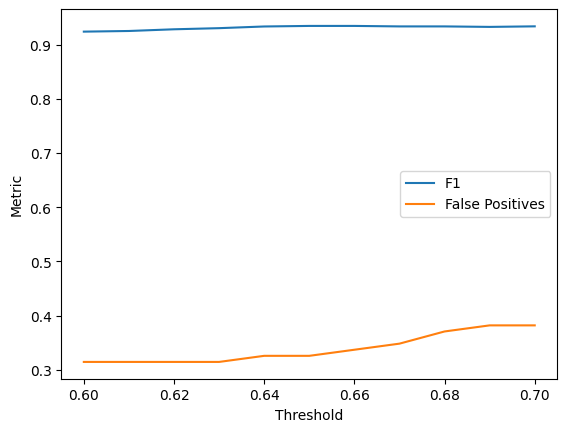

In [ ]:
# Mental-RoBERTa + Relabeled + Personality + NLI Evaluation with Dual Optimization
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

# ===== Load both datasets =====
# Performance test dataset
df_performance = pd.read_csv('../dataset/testing_1000_samples_2.csv')
true_labels_perf = df_performance['true_class'].map({'non-suicide':0, 'suicide':1}).values

# False positive test dataset
df_fp = pd.read_csv('../dataset/false_positive_test_set_with_personality.csv')  
true_labels_fp = [0] * len(df_fp)  # All should be non-suicide

print(f"Performance dataset size: {len(df_performance)}")
print(f"FP test dataset size: {len(df_fp)}")

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Load personality features for both datasets =====
personality_features_perf = df_performance[["extraversion", "agreeableness", "neuroticism"]].values
personality_features_perf = torch.tensor(personality_features_perf, dtype=torch.float32).to(device)

personality_features_fp = df_fp[["extraversion", "agreeableness", "neuroticism"]].values
personality_features_fp = torch.tensor(personality_features_fp, dtype=torch.float32).to(device)

model_dir = "../saved_models/mental_roberta_personality"
# ===== Tokenizer =====
bert_tokenizer = AutoTokenizer.from_pretrained(model_dir)

class RoBertaWithPersonality(RobertaPreTrainedModel):
    def __init__(self, config, personality_feat_dim=3, num_labels=2):
        super().__init__(config)
        self.bert = AutoModel.from_pretrained(model_dir, config=config)
        bert_hidden_size = config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(bert_hidden_size + personality_feat_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )

        self.init_weights()

    def forward(self, input_ids, attention_mask, personality_feats, labels=None):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = bert_outputs.last_hidden_state[:, 0, :]  # CLS token embedding
        combined = torch.cat((cls_output, personality_feats), dim=1)
        logits = self.classifier(combined)

        return logits

# ===== Load pretrained BERT + Personality model =====
config = AutoConfig.from_pretrained(model_dir, num_labels=2)
bert_personality_model = RoBertaWithPersonality.from_pretrained(model_dir, config=config)
bert_personality_model.to(device).eval()

# ===== Load pretrained NLI model =====
nli_model_name = "tasksource/deberta-small-long-nli"
nli_model = AutoModelForSequenceClassification.from_pretrained(nli_model_name).to(device).eval()
nli_tokenizer = AutoTokenizer.from_pretrained(nli_model_name)

# ===== Negative hypotheses for NLI filtering =====
negative_hypotheses = [
    "The author discusses suicide in general, awareness, or prevention, not personal suicidal thoughts.",
    "The post shares support, resources, or hotlines, not the author's own suicidal intent.",
    "The author reflects to inspire or thank others, not describing current suicidal thoughts."
]

# ===== Helper: NLI negative filtering =====
def nli_negative_filter(post, threshold=0.65):
    max_neg_entail_prob = 0
    for hypo in negative_hypotheses:
        inputs = nli_tokenizer(post, hypo, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = nli_model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1)[0]  # [entail, neutral, contradict]
            entail_prob = probs[0].item()  # entailment probability
        max_neg_entail_prob = max(max_neg_entail_prob, entail_prob)
    return max_neg_entail_prob >= threshold

# ===== Function to evaluate dataset with specific threshold =====
def evaluate_dataset(df, personality_features, true_labels, threshold, dataset_name="Dataset"):
    final_predictions = []
    batch_size = 16
    
    for i in range(0, len(df), batch_size):
        batch_texts = df['cleaned_text'][i:i+batch_size].tolist()
        batch_personality = personality_features[i:i+batch_size]

        # BERT tokenization
        encodings = bert_tokenizer(
            batch_texts,
            add_special_tokens=True,
            return_attention_mask=True,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )
        input_ids = encodings['input_ids'].to(device)
        attention_mask = encodings['attention_mask'].to(device)

        # BERT + Personality predictions
        with torch.no_grad():
            logits = bert_personality_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                personality_feats=batch_personality
            )
            batch_preds = torch.argmax(logits, dim=1).cpu().numpy()

        # Apply NLI negative filtering with current threshold
        for text, pred in zip(batch_texts, batch_preds):
            if pred == 1:  # initially predicted as suicide
                is_negative = nli_negative_filter(text, threshold=threshold)
                final_predictions.append(0 if is_negative else 1)
            else:
                final_predictions.append(pred)

        # Free GPU memory
        torch.cuda.empty_cache()
    
    # Calculate metrics
    cm = confusion_matrix(true_labels, final_predictions)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    precision = precision_score(true_labels, final_predictions, zero_division=0)
    recall = recall_score(true_labels, final_predictions, zero_division=0)
    f1 = f1_score(true_labels, final_predictions, zero_division=0)
    accuracy = np.mean(np.array(final_predictions) == true_labels)
    
    return {
        'threshold': threshold,
        'dataset': dataset_name,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'fpr': fpr,
        'fp': fp,
        'tp': tp,
        'tn': tn,
        'fn': fn,
        'predictions': final_predictions
    }

# ===== Multi-objective threshold optimization =====
thresholds_to_test = [0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70]
results = []

print("Testing thresholds for dual optimization (performance + FP reduction)...")
for threshold in thresholds_to_test:
    print(f"Testing threshold: {threshold:.2f}")
    
    # Evaluate on performance dataset
    result_perf = evaluate_dataset(df_performance, personality_features_perf, true_labels_perf, threshold, "Performance")
    
    # Evaluate on FP dataset
    result_fp = evaluate_dataset(df_fp, personality_features_fp, true_labels_fp, threshold, "FP_Test")
    
    results.append(result_perf)
    results.append(result_fp)
    
    print(f"  Performance - F1: {result_perf['f1_score']:.4f}, FP: {result_perf['fp']}")
    print(f"  FP Test - FPR: {result_fp['fpr']:.4f}, FP: {result_fp['fp']}")

# ===== Find optimal threshold using multi-objective optimization =====
results_df = pd.DataFrame(results)

# Separate results by dataset
perf_results = results_df[results_df['dataset'] == 'Performance']
fp_results = results_df[results_df['dataset'] == 'FP_Test']

# Create combined scoring metric
combined_scores = []
for threshold in thresholds_to_test:
    perf_data = perf_results[perf_results['threshold'] == threshold].iloc[0]
    fp_data = fp_results[fp_results['threshold'] == threshold].iloc[0]
    
    # Weighted combination of F1 (performance) and 1-FPR (FP reduction)
    # Adjust weights based on your priorities (0.7:0.3 favors performance, 0.5:0.5 balanced)
    weight_performance = 0.8
    weight_fp = 0.2
    
    # Normalize F1 score (0-1)
    normalized_f1 = perf_data['f1_score']
    
    # Normalize FP reduction (1-FPR, higher is better)
    normalized_fp_reduction = 1 - fp_data['fpr']
    
    # Combined score
    combined_score = (weight_performance * normalized_f1) + (weight_fp * normalized_fp_reduction)
    
    combined_scores.append({
        'threshold': threshold,
        'combined_score': combined_score,
        'f1_score': perf_data['f1_score'],
        'fpr': fp_data['fpr'],
        'fp_count': fp_data['fp'],
        'performance_fp': perf_data['fp']
    })

combined_df = pd.DataFrame(combined_scores)

df_valid = combined_df[combined_df['f1_score'] >= 0.93]

# Select threshold with the highest combined score
best_idx = df_valid['combined_score'].idxmax()
best_threshold = df_valid.loc[best_idx, 'threshold']
best_combined_score = combined_df.loc[best_idx, 'combined_score']
best_f1 = df_valid.loc[best_idx, 'f1_score']
best_fp = df_valid.loc[best_idx, 'fp_count']

print(f"Selected threshold: {best_threshold}")
print(f"F1 Score: {best_f1}")
print(f"False Positives: {best_fp}")
print("\n" + "="*60)
print("MULTI-OBJECTIVE THRESHOLD OPTIMIZATION RESULTS")
print("="*60)
print(combined_df.round(4))
print(f"\nBest threshold: {best_threshold:.2f}")
print(f"Combined score: {best_combined_score:.4f}")
print(f"Performance F1: {combined_df.loc[best_idx, 'f1_score']:.4f}")
print(f"FP Test FPR: {combined_df.loc[best_idx, 'fpr']:.4f}")
print(f"FP Count: {combined_df.loc[best_idx, 'fp_count']}")

# ===== Final evaluation with optimal threshold =====
print(f"\nFinal evaluation with optimal threshold: {best_threshold:.2f}")

# Performance dataset
final_perf = evaluate_dataset(df_performance, personality_features_perf, true_labels_perf, best_threshold, "Performance_Final")
print("\nPerformance Dataset Results:")
print(f"F1 Score: {final_perf['f1_score']:.4f}")
print(f"Precision: {final_perf['precision']:.4f}")
print(f"Recall: {final_perf['recall']:.4f}")
print(f"False Positives: {final_perf['fp']}")

# FP dataset
final_fp = evaluate_dataset(df_fp, personality_features_fp, true_labels_fp, best_threshold, "FP_Test_Final")
print("\nFP Test Dataset Results:")
print(f"False Positive Rate: {final_fp['fpr']:.4f}")
print(f"False Positives: {final_fp['fp']}")
print(f"True Negatives: {final_fp['tn']}")

# ===== Comparison with baseline (no NLI) =====
print("\n" + "="*40)
print("COMPARISON WITH BASELINE (NO NLI FILTERING)")
print("="*40)

# Baseline for performance dataset
baseline_perf = evaluate_dataset(df_performance, personality_features_perf, true_labels_perf, 0.0, "Baseline")
print(f"Performance Baseline F1: {baseline_perf['f1_score']:.4f} → With NLI: {final_perf['f1_score']:.4f}")
print(f"Performance Baseline FP: {baseline_perf['fp']} → With NLI: {final_perf['fp']}")

# Baseline for FP dataset (all should be 0 predictions)
baseline_fp_predictions = []
for i in range(0, len(df_fp), 16):
    batch_personality = personality_features_fp[i:i+16]
    batch_texts = df_fp['cleaned_text'][i:i+16].tolist()
    
    encodings = bert_tokenizer(
        batch_texts,
        add_special_tokens=True,
        return_attention_mask=True,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    with torch.no_grad():
        logits = bert_personality_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            personality_feats=batch_personality
        )
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
        baseline_fp_predictions.extend(batch_preds.tolist())

baseline_fp_count = sum(baseline_fp_predictions)
print(f"FP Test Baseline FP: {baseline_fp_count} → With NLI: {final_fp['fp']}")
print(f"FP Reduction: {((baseline_fp_count - final_fp['fp']) / baseline_fp_count * 100):.1f}%")

import matplotlib.pyplot as plt
plt.plot(thresholds_to_test, perf_results['f1_score'], label='F1')
plt.plot(thresholds_to_test, fp_results['fpr'], label='False Positives')
plt.xlabel('Threshold')
plt.ylabel('Metric')
plt.legend()
plt.show()